<a href="https://colab.research.google.com/github/Snehaganupa/Snehaganupa/blob/main/convNeXt_Tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from timm import create_model
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms import RandAugment
import numpy as np
from tqdm import tqdm  # Progress bar

In [2]:
# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 3. Data Preparation (with RandAugment)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split into training and validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 73.7MB/s]


In [4]:
# 4. Model, Loss, Optimizer, Scheduler
model = create_model('convnext_tiny', pretrained=True, num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
scaler = torch.cuda.amp.GradScaler()  # Mixed Precision


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

<ipython-input-4-70b02e7ec152>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision


In [6]:
# 5. Training Loop with Early Stopping, Mixed Precision, Best Model Saving
num_epochs = 50
patience = 5
trigger_times = 0
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Val Acc: {val_acc:.2f}%")

    # Early Stopping and Best Model Saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break


Epoch 1/50:   0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-6-797bdcf28a5e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 625/625 [00:49<00:00, 12.75it/s]


Epoch [1/50], Loss: 2.3035, Val Acc: 9.66%
Best model saved!


Epoch 2/50: 100%|██████████| 625/625 [00:48<00:00, 12.89it/s]


Epoch [2/50], Loss: 2.3038, Val Acc: 10.56%
Best model saved!


Epoch 3/50: 100%|██████████| 625/625 [00:47<00:00, 13.10it/s]


Epoch [3/50], Loss: 2.3009, Val Acc: 10.44%


Epoch 4/50: 100%|██████████| 625/625 [00:48<00:00, 12.86it/s]


Epoch [4/50], Loss: 2.2496, Val Acc: 17.08%
Best model saved!


Epoch 5/50: 100%|██████████| 625/625 [00:48<00:00, 12.94it/s]


Epoch [5/50], Loss: 2.1140, Val Acc: 24.10%
Best model saved!


Epoch 6/50: 100%|██████████| 625/625 [00:48<00:00, 12.91it/s]


Epoch [6/50], Loss: 1.9895, Val Acc: 28.89%
Best model saved!


Epoch 7/50: 100%|██████████| 625/625 [00:49<00:00, 12.68it/s]


Epoch [7/50], Loss: 1.8740, Val Acc: 31.06%
Best model saved!


Epoch 8/50: 100%|██████████| 625/625 [00:48<00:00, 12.91it/s]


Epoch [8/50], Loss: 1.7843, Val Acc: 34.67%
Best model saved!


Epoch 9/50: 100%|██████████| 625/625 [00:48<00:00, 12.92it/s]


Epoch [9/50], Loss: 1.7256, Val Acc: 36.71%
Best model saved!


Epoch 10/50: 100%|██████████| 625/625 [00:47<00:00, 13.11it/s]


Epoch [10/50], Loss: 1.6627, Val Acc: 40.22%
Best model saved!


Epoch 11/50: 100%|██████████| 625/625 [00:49<00:00, 12.57it/s]


Epoch [11/50], Loss: 1.6013, Val Acc: 41.63%
Best model saved!


Epoch 12/50: 100%|██████████| 625/625 [00:47<00:00, 13.10it/s]


Epoch [12/50], Loss: 1.5460, Val Acc: 43.50%
Best model saved!


Epoch 13/50: 100%|██████████| 625/625 [00:48<00:00, 12.89it/s]


Epoch [13/50], Loss: 1.4940, Val Acc: 46.48%
Best model saved!


Epoch 14/50: 100%|██████████| 625/625 [00:47<00:00, 13.02it/s]


Epoch [14/50], Loss: 1.4505, Val Acc: 49.50%
Best model saved!


Epoch 15/50: 100%|██████████| 625/625 [00:49<00:00, 12.65it/s]


Epoch [15/50], Loss: 1.4103, Val Acc: 50.83%
Best model saved!


Epoch 16/50: 100%|██████████| 625/625 [00:47<00:00, 13.12it/s]


Epoch [16/50], Loss: 1.3591, Val Acc: 51.91%
Best model saved!


Epoch 17/50: 100%|██████████| 625/625 [00:47<00:00, 13.06it/s]


Epoch [17/50], Loss: 1.3227, Val Acc: 52.90%
Best model saved!


Epoch 18/50: 100%|██████████| 625/625 [00:48<00:00, 12.98it/s]


Epoch [18/50], Loss: 1.2841, Val Acc: 54.08%
Best model saved!


Epoch 19/50: 100%|██████████| 625/625 [00:48<00:00, 12.82it/s]


Epoch [19/50], Loss: 1.2461, Val Acc: 55.98%
Best model saved!


Epoch 20/50: 100%|██████████| 625/625 [00:48<00:00, 12.77it/s]


Epoch [20/50], Loss: 1.2119, Val Acc: 56.40%
Best model saved!


Epoch 21/50: 100%|██████████| 625/625 [00:48<00:00, 13.00it/s]


Epoch [21/50], Loss: 1.1783, Val Acc: 57.96%
Best model saved!


Epoch 22/50: 100%|██████████| 625/625 [00:48<00:00, 12.89it/s]


Epoch [22/50], Loss: 1.1432, Val Acc: 59.12%
Best model saved!


Epoch 23/50: 100%|██████████| 625/625 [00:48<00:00, 12.82it/s]


Epoch [23/50], Loss: 1.1106, Val Acc: 60.58%
Best model saved!


Epoch 24/50: 100%|██████████| 625/625 [00:48<00:00, 12.92it/s]


Epoch [24/50], Loss: 1.0752, Val Acc: 62.11%
Best model saved!


Epoch 25/50: 100%|██████████| 625/625 [00:47<00:00, 13.04it/s]


Epoch [25/50], Loss: 1.0496, Val Acc: 63.69%
Best model saved!


Epoch 26/50: 100%|██████████| 625/625 [00:48<00:00, 12.87it/s]


Epoch [26/50], Loss: 1.0166, Val Acc: 63.39%


Epoch 27/50: 100%|██████████| 625/625 [00:50<00:00, 12.48it/s]


Epoch [27/50], Loss: 0.9912, Val Acc: 64.59%
Best model saved!


Epoch 28/50: 100%|██████████| 625/625 [00:49<00:00, 12.68it/s]


Epoch [28/50], Loss: 0.9658, Val Acc: 65.66%
Best model saved!


Epoch 29/50: 100%|██████████| 625/625 [00:48<00:00, 12.78it/s]


Epoch [29/50], Loss: 0.9423, Val Acc: 65.83%
Best model saved!


Epoch 30/50: 100%|██████████| 625/625 [00:48<00:00, 12.80it/s]


Epoch [30/50], Loss: 0.9187, Val Acc: 66.68%
Best model saved!


Epoch 31/50: 100%|██████████| 625/625 [00:49<00:00, 12.64it/s]


Epoch [31/50], Loss: 0.8894, Val Acc: 67.86%
Best model saved!


Epoch 32/50: 100%|██████████| 625/625 [00:48<00:00, 12.83it/s]


Epoch [32/50], Loss: 0.8708, Val Acc: 68.68%
Best model saved!


Epoch 33/50: 100%|██████████| 625/625 [00:47<00:00, 13.02it/s]


Epoch [33/50], Loss: 0.8531, Val Acc: 67.50%


Epoch 34/50: 100%|██████████| 625/625 [00:48<00:00, 12.83it/s]


Epoch [34/50], Loss: 0.8353, Val Acc: 69.01%
Best model saved!


Epoch 35/50: 100%|██████████| 625/625 [00:49<00:00, 12.65it/s]


Epoch [35/50], Loss: 0.8129, Val Acc: 69.83%
Best model saved!


Epoch 36/50: 100%|██████████| 625/625 [00:48<00:00, 12.78it/s]


Epoch [36/50], Loss: 0.7990, Val Acc: 71.22%
Best model saved!


Epoch 37/50: 100%|██████████| 625/625 [00:48<00:00, 12.85it/s]


Epoch [37/50], Loss: 0.7777, Val Acc: 70.31%


Epoch 38/50: 100%|██████████| 625/625 [00:49<00:00, 12.70it/s]


Epoch [38/50], Loss: 0.7694, Val Acc: 72.35%
Best model saved!


Epoch 39/50: 100%|██████████| 625/625 [00:49<00:00, 12.56it/s]


Epoch [39/50], Loss: 0.7490, Val Acc: 71.17%


Epoch 40/50: 100%|██████████| 625/625 [00:48<00:00, 12.84it/s]


Epoch [40/50], Loss: 0.7378, Val Acc: 71.90%


Epoch 41/50: 100%|██████████| 625/625 [00:48<00:00, 12.86it/s]


Epoch [41/50], Loss: 0.7226, Val Acc: 71.21%


Epoch 42/50: 100%|██████████| 625/625 [00:47<00:00, 13.23it/s]


Epoch [42/50], Loss: 0.7111, Val Acc: 73.73%
Best model saved!


Epoch 43/50: 100%|██████████| 625/625 [00:49<00:00, 12.60it/s]


Epoch [43/50], Loss: 0.6931, Val Acc: 72.19%


Epoch 44/50: 100%|██████████| 625/625 [00:47<00:00, 13.03it/s]


Epoch [44/50], Loss: 0.6889, Val Acc: 72.95%


Epoch 45/50: 100%|██████████| 625/625 [00:48<00:00, 12.87it/s]


Epoch [45/50], Loss: 0.6760, Val Acc: 73.48%


Epoch 46/50: 100%|██████████| 625/625 [00:48<00:00, 12.91it/s]


Epoch [46/50], Loss: 0.6656, Val Acc: 73.84%
Best model saved!


Epoch 47/50: 100%|██████████| 625/625 [00:48<00:00, 12.91it/s]


Epoch [47/50], Loss: 0.6502, Val Acc: 73.88%
Best model saved!


Epoch 48/50: 100%|██████████| 625/625 [00:48<00:00, 12.80it/s]


Epoch [48/50], Loss: 0.6329, Val Acc: 74.60%
Best model saved!


Epoch 49/50: 100%|██████████| 625/625 [00:48<00:00, 12.92it/s]


Epoch [49/50], Loss: 0.6240, Val Acc: 74.93%
Best model saved!


Epoch 50/50: 100%|██████████| 625/625 [00:48<00:00, 12.79it/s]


Epoch [50/50], Loss: 0.6096, Val Acc: 75.92%
Best model saved!


In [7]:
# 6. Load Best Model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [8]:
# 7. Final Test Evaluation
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(f"\n Final Test Accuracy: {100 * correct / total:.2f}%")



 Final Test Accuracy: 79.64%


In [9]:
test_accuracy = 84.89  # Or however you calculate it dynamically
error_rate = 100 - test_accuracy
print(f"Test Error Rate: {error_rate:.2f}%")


Test Error Rate: 15.11%



Confusion Matrix:
 [[838  12  34   9  21   5   5  12  49  15]
 [ 12 894   3   5   0   4   7   2  20  53]
 [ 54   2 724  21  85  51  39  11   6   7]
 [ 27   7  63 472  87 243  59  17  16   9]
 [  7   2  35  15 850  30  20  34   6   1]
 [  9   2  39  69  67 753  21  28   7   5]
 [  5   3  35  24  28  30 867   2   5   1]
 [ 16   0  21  13  72  42   4 828   0   4]
 [ 51  17  11   3   8   6   3   2 888  11]
 [ 28  56   8   7   2   3   5  10  31 850]]


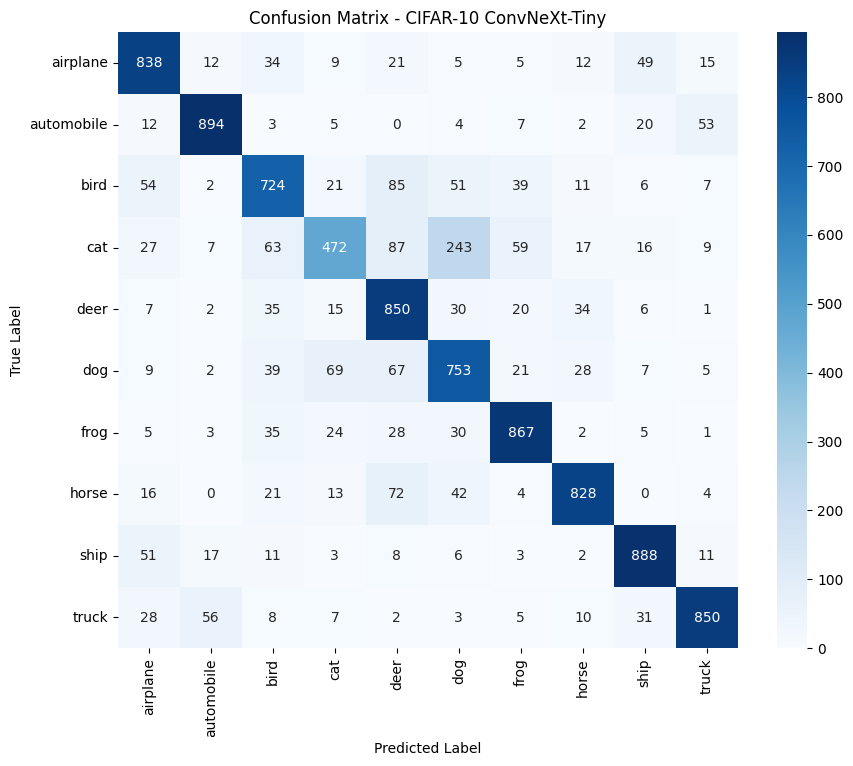


Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.84      0.82      1000
  automobile       0.90      0.89      0.90      1000
        bird       0.74      0.72      0.73      1000
         cat       0.74      0.47      0.58      1000
        deer       0.70      0.85      0.77      1000
         dog       0.65      0.75      0.69      1000
        frog       0.84      0.87      0.85      1000
       horse       0.88      0.83      0.85      1000
        ship       0.86      0.89      0.88      1000
       truck       0.89      0.85      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



In [10]:
#  8. Confusion Matrix + Classification Report
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.dataset.classes, yticklabels=trainset.dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CIFAR-10 ConvNeXt-Tiny")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=trainset.dataset.classes))
